<a href="https://colab.research.google.com/github/T-Zara/googleColab/blob/main/8ClassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#!pip install opencv-python-headless scikit-learn scikit-image tensorflow
#!pip install scikit-optimize
#!pip install matplotlib
#!pip install seaborn

In [60]:
import os
import cv2
import numpy as np
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [61]:
class DatasetPreparation:
    def __init__(self, base_dir, dataset_mode):
        self.BASE_DIR = base_dir
        self.DATASET_MODE = dataset_mode
        self.GENERAL_CLASSES = ["benign", "malignant"]
        self.BENIGN_SUB_CLASSES = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
        self.MALIGNANT_SUB_CLASSES = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]

    def get_paths_n_labels(self):
        x = []
        label = []

        for ix1, a in enumerate(self.GENERAL_CLASSES):
            sub_classes = self.BENIGN_SUB_CLASSES if ix1 == 0 else self.MALIGNANT_SUB_CLASSES
            for ix2, b in enumerate(sub_classes):
                path1 = os.path.join(self.BASE_DIR, a, "SOB", b)
                for c in os.listdir(path1):
                    path2 = os.path.join(path1, c, self.DATASET_MODE)
                    for img_name in os.listdir(path2):
                        img_path = os.path.join(path2, img_name)

                        # x
                        x.append(img_path)

                        # y - One-hot encode for 8 classes
                        targets = np.zeros(8, dtype=np.float32)
                        if ix1 == 0: # Benign
                            targets[ix2] = 1.
                        else: # Malignant
                            targets[ix2 + 4] = 1.

                        label.append(targets)

        return x, label

base_dir = "/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast"
dataset_mode = "200X"
data_prep = DatasetPreparation(base_dir, dataset_mode)
x, label = data_prep.get_paths_n_labels()


In [62]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient = cv2.magnitude(sobelx, sobely)

    # Normalize the gradient to 8-bit single-channel
    gradient_8bit = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    _, binary = cv2.threshold(gradient_8bit, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    distance = ndi.distance_transform_edt(binary)

    local_maxi = cv2.dilate(cv2.erode(distance, None), None)

    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=binary)

    processed_image = np.zeros_like(image)
    for label in np.unique(labels):
        mask = labels == label
        processed_image[mask] = image[mask]

    return processed_image



In [63]:
# Example usage:
# Assuming 'x' is a list of image paths and 'label' is a corresponding list of labels
preprocessed_images = [preprocess_image(img_path) for img_path in x]

# Resize images to a consistent size
IMG_SIZE = (224, 224)  # Set your desired image size
resized_images = [cv2.resize(img, IMG_SIZE) for img in preprocessed_images]

preprocessed_images = np.array(resized_images)  # Now the images have the same shape
labels = np.array(label)

In [64]:
def build_clstm_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Reshape((-1, 128))(x)
    x = layers.LSTM(64)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (preprocessed_images.shape[1], preprocessed_images.shape[2], preprocessed_images.shape[3])
num_classes = 8
model = build_clstm_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 676, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,008 (593.78 KB)

 Trainable params: 152,008 (593.78 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model.fit(preprocessed_images, labels, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.4091 - loss: 1.7429 - val_accuracy: 0.0000e+00 - val_loss: 3.8202
Epoch 2/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.5606 - loss: 1.3805 - val_accuracy: 0.0000e+00 - val_loss: 4.8048
Epoch 3/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.5645 - loss: 1.3682 - val_accuracy: 0.0000e+00 - val_loss: 5.3499
Epoch 4/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.5550 - loss: 1.3710 - val_accuracy: 0.0000e+00 - val_loss: 5.9221
Epoch 5/5
51/51 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.5503 - loss: 1.3825 - val_accuracy: 0.0000e+00 - val_loss: 5.9550


In [66]:
type(models)

module

In [67]:
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_extractor.predict(preprocessed_images)
features = features.reshape(features.shape[0], -1)  # Flatten the features for SVM


64/64 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step


In [68]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
svm = SVC()
params = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'gamma': (1e-6, 1e+1, 'log-uniform'),
}

opt = BayesSearchCV(svm, params, n_iter=32, cv=3, n_jobs=-1)
opt.fit(X_train, y_train_labels)

y_pred = opt.predict(X_test)

# Convert y_test to single-label format to match y_pred
y_test_single = np.argmax(y_test, axis=1)
print(classification_report(y_test_single, y_pred))


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.25      0.02      0.03        61
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        34
           4       0.41      0.98      0.58       167
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        35
           7       0.00      0.00      0.00        26

    accuracy                           0.41       405
   macro avg       0.08      0.12      0.08       405
weighted avg       0.21      0.41      0.24       405



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
def calculate_accuracy(y_true, y_pred):
    accuracy = accuracy_score(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    return accuracy


<h1>Confusion Metrics Visualization</h1>

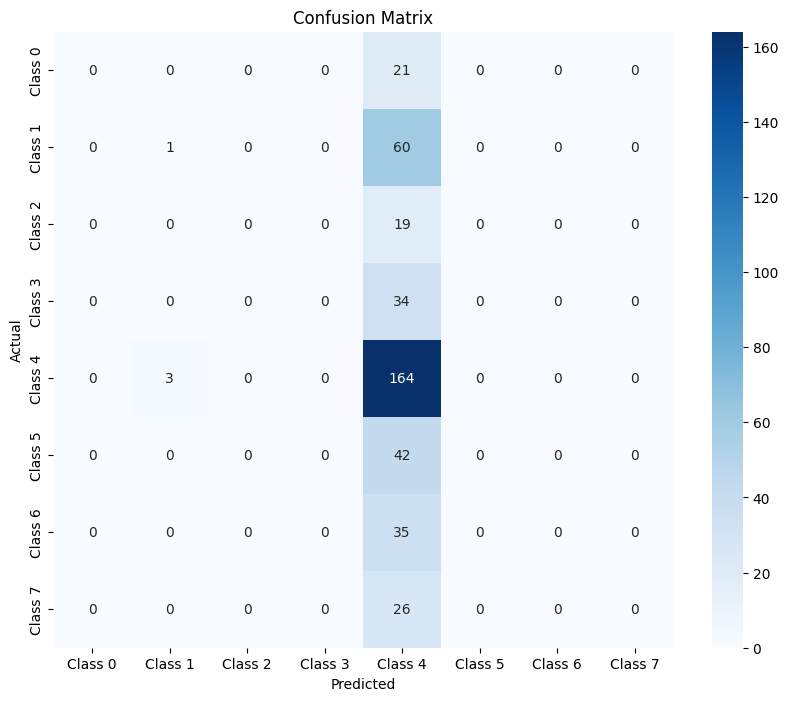

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred)
    plt.figure(figsize=(10, 8))  # Adjust figure size for more classes
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Replace with your actual class names in the correct order



class_names = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma", " ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
plot_confusion_matrix(y_test, y_pred, classes=class_names)

In [71]:
def main():
    pass  # This function is currently not used

if __name__ == "__main__":
    main()